In [1]:
using Random

function sde(l, N, p=1, T=0.1, sig=1.0, x0=1.2)
    # 2 level estimator for the solution to the SDE:
    # dX = -X^p*dt+sig*dW using Euler Maruyama method
    # at time T using nf steps on the fine and nc on the coarse grid.
    # Here, dW is the standard Wiener process.

    # Returns an array of sums that contains:
    # sums[1] = nf * N
    # sums[2] = sum(dP)
    # sums[3] = sum(dP^2)
    # sums[4] = sum(dP^3)
    # sums[5] = sum(dP^4)
    # sums[6] = sum(Pf)
    # sums[7] = sum(Pf^2)
    # where dP=Xf if l=1 and dP = Xf-Xc othwerwise
    # Here, Pf is Xf, i.e. X at t=T using 2^(l-1) steps
    # and Pc is Xc, i.e. X at t=T using nc=nf/2 steps
    
    nf = 2 ^ (l-1)
    hf = T / nf

    sums = zeros(7)
    X0 = x0 * ones(N)

    Xf = copy(X0)
    Xc = copy(X0)
    if l == 1
        dWf = sqrt(hf) * randn(N)
        Xf .= Xf .- Xf .^ p .* hf .+ sqrt(2.0) * sig * dWf
    else
        nc = Int(nf / 2)
        hc = T / nc
        for n = 1:nc
            dWf0 = sqrt(hf) * randn(N)
            dWf1 = sqrt(hf) * randn(N)
            Xf .= Xf .- Xf .^ p .* hf .+ sqrt(2.0) * sig * dWf0
            Xf .= Xf .- Xf .^ p .* hf .+ sqrt(2.0) * sig * dWf1

            dWc = dWf0 .+ dWf1
            Xc .= Xc .- Xc .^ p .* hc .+ sqrt(2.0) * sig * dWc
        end
    end

    dP = Xf .- Xc
    Pf = copy(Xf)

    if l == 1
        dP .= Pf
    end

    sums[1] = nf * N
    sums[2] = sum(dP)
    sums[3] = sum(dP .^ 2)
    sums[4] = sum(dP .^ 3)
    sums[5] = sum(dP .^ 4)
    sums[6] = sum(Pf)
    sums[7] = sum(Pf .^ 2)
    
    return sums
end

sde (generic function with 5 methods)

In [2]:
sde(3, 2000)

7-element Vector{Float64}:
 8000.0
    3.2084064956525635
    0.12162215259474012
    0.0005617666029335151
    2.2038228526560964e-5
 2163.6193211473
 2714.5262137817717

In [3]:
using Random
using CurveFit

function mlmc(Lmin, Lmax, N0, eps, p=1) 
   #Multi-Level Monte Carlo routine
    
    #Lmin  = minimum level of refinement       >= 3
    #Lmax  = maximum level of refinement       >= Lmin
    #N0    = initial number of samples         > 0
    #eps   = desired accuracy (rms error)      > 0 
 
    #Here sde(l,N,p) is low-level function
    #     l       = level
    #     N       = number of paths
    #     p       = the order of drift term
    #     which returns sums
    #     sums[1] = sum(cost)
    #     sums[2] = sum(Y)
    #     sums[3] = sum(Y^2)
    #     where Y are iid samples with expected value:
    #     E[P_1]           on level 1
    #     E[P_l - P_{l-1}] on level l>1

    #alpha -> weak error is  O(2^{-alpha*l})
    #beta  -> variance is    O(2^{-beta*l})
    #gamma -> sample cost is O(2^{gamma*l})
        
    #P   = value
    #Nl  = number of samples at each level
    #Cl  = average cost of samples at each level
    
    suml = zeros(3, Lmax)
    dNl = zeros(Int, Lmax)
    ml = zeros(Lmax)
    Vl = zeros(Lmax)

    if Lmin < 3
        println("error: needs Lmin >= 3")
        exit(1)
    end
    
    if Lmax < Lmin
        println("error: needs Lmax >= Lmin")
        exit(1)
    end
    
    if N0 <= 0 || eps <= 0.0
        println("error: needs N > 0, eps > 0")
        exit(1)
    end

    L = Lmin

    alpha = 0.0
    beta = 0.0
    gamma = 0.0
    theta = 0.25

    Nl = zeros(Int, Lmax)
    Cl = zeros(Lmax)
    NlCl = zeros(Lmax)
    dNl[1:Lmin] .= N0

    converged = false
    while !converged
        for l = 1:L
            if dNl[l] > 0
                sums = sde(l, dNl[l], p)
                suml[1, l] += 1.0 * dNl[l]
                suml[2, l] += sums[2]
                suml[3, l] += sums[3]
                NlCl[l] += sums[1]
            end
        end

        for l = 1:L
            if suml[1, l] > 0
                ml[l] = abs(suml[2, l] / suml[1, l])
                Vl[l] = max(suml[3, l] / suml[1, l] - ml[l] * ml[l], 0.0)
                Cl[l] = NlCl[l] / suml[1, l]
            end
            if l > 2
                ml[l] = max(ml[l], 0.5 * ml[l-1] / (2.0 ^ alpha))
                Vl[l] = max(Vl[l], 0.5 * Vl[l-1] / (2.0 ^ beta))
            end
        end
        
        s = sum(sqrt.(Vl .* Cl))
        for l = 1:L
            dNl[l] = ceil(max(0.0, sqrt(Vl[l] / Cl[l]) * s / ((1.0 - theta) * eps * eps) - suml[1, l]))
        end
        
        xl = [l * 1.0 for l = 2:L]
        yl = -log2.(ml[2:L])
        fit = linear_fit(xl, yl)
        alpha = max(fit[2], 0.5)

        yl = -log2.(Vl[2:L])
        fit = linear_fit(xl, yl)
        beta = max(fit[2], 0.5)

        yl = log2.(Cl[2:L])
        fit = linear_fit(xl, yl)
        gamma = max(fit[2], 0.5)

        sr = 0
        for l = 1:L
            sr += max(0, 1.0 * dNl[l] - (0.01 * suml[1, l]))
        end

        if abs(sr) < 1e-5
            converged = true
            rem = ml[L] / (2.0 ^ alpha - 1.0)
            if rem > sqrt(theta) * eps
                if L == Lmax
                    println("*** failed to achieve weak convergence ***")
                else
                    converged = false
                    L += 1
                    Vl[L] = Vl[L-1] / (2.0 ^ beta)
                    Cl[L] = Cl[L-1] * (2.0 ^ gamma)
                    s = sum(sqrt.(Vl .* Cl))
                    for l = 1:L
                        dNl[l] = ceil(max(0.0, sqrt(Vl[l] / Cl[l]) * s / ((1.0 - theta) * eps * eps) - suml[1, l]))
                    end
                end
            end
        end
    end

    P = 0.0
    for l = 1:L
        P += suml[2, l] / suml[1, l]
        Nl[l] = suml[1, l]
        Cl[l] = NlCl[l] / Nl[l]
    end

    return P, Nl[1:L], Cl[1:L], Vl[1:L], alpha, beta, gamma
end

mlmc (generic function with 2 methods)

In [4]:
mlmc(3, 10, 200, 0.001, 1)

(1.0872606250893602, [351276, 8638, 4319, 914, 317], [1.0, 2.0, 4.0, 8.0, 16.0], [0.20013176330965088, 0.0002441522767890192, 6.000724166829574e-5, 1.3679996821705568e-5, 3.5462939339822962e-6], 0.9990587050295631, 2.044904462835331, 1.0)

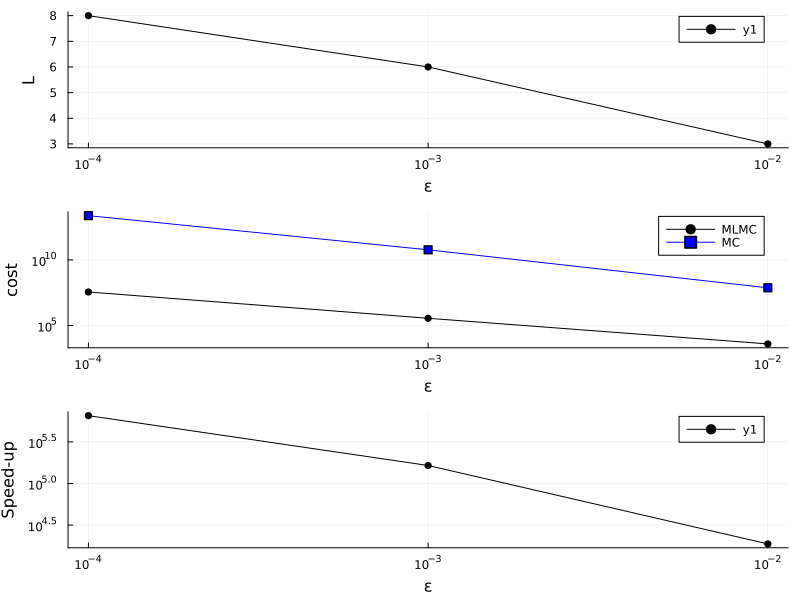

In [5]:
using Plots
using Random
using CurveFit

p = 1
eps = [1e-2, 1e-3, 1e-4]
levels = zeros(Int, length(eps))
costs = zeros(length(eps))
costs_sd = zeros(length(eps))

for (i, ε) in enumerate(eps)
    P, Nl, Cl, Vl, alpha, beta, gamma = mlmc(3, 10, 100, ε, p)
    L = length(Nl)
    levels[i] = L
    costs[i] = sum(Nl .* Cl)

    # Sample cost of standard MC at Lth level
    Ntest = 10000
    sums = sde(L, Ntest, p)
    varL = max(sums[7] / Ntest - (sums[6] / Ntest)^2, 1e-10)
    NlCl = sums[1]
    costs_sd[i] = NlCl * varL / ε^2
end

# Plot levels vs. ε
plt_levels = plot(eps, levels, color="black", ylabel="L", xlabel="ε", marker=:circle)
xaxis!(plt_levels, :log)
yaxis!(plt_levels, integer=true)

# Plot costs and costs_sd vs. ε
plt_costs = plot(eps, costs, color="black", label="MLMC", marker=:circle)
plot!(eps, costs_sd, color="blue", label="MC", xlabel="ε", ylabel="cost", marker=:square)
xaxis!(plt_costs, :log)
yaxis!(plt_costs, :log)

# Plot Speed-up vs. ε
speedup_p1 = costs_sd ./ costs
plt_speedup_p1 = plot(eps, speedup_p1, color="black", ylabel="Speed-up", xlabel="ε", marker=:circle)
xaxis!(plt_speedup_p1, :log)
yaxis!(plt_speedup_p1, :log)

plot(plt_levels, plt_costs, plt_speedup_p1, layout=(3, 1), size=(800, 600))

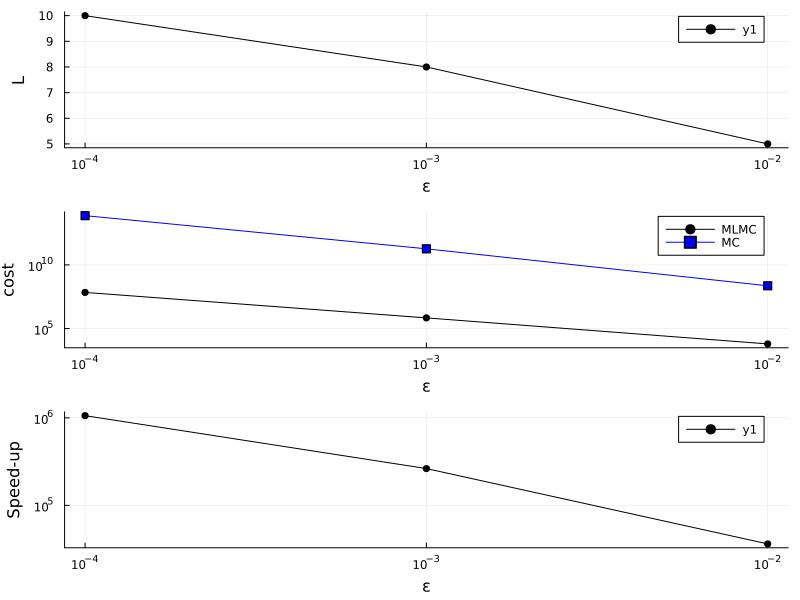

In [6]:
using Plots
using Random
using CurveFit

p = 3
eps = [1e-2, 1e-3, 1e-4]
levels = zeros(Int, length(eps))
costs = zeros(length(eps))
costs_sd = zeros(length(eps))

for (i, ε) in enumerate(eps)
    P, Nl, Cl, Vl, alpha, beta, gamma = mlmc(3, 10, 100, ε, p)
    L = length(Nl)
    levels[i] = L
    costs[i] = sum(Nl .* Cl)

    # Sample cost of standard MC at Lth level
    Ntest = 10000
    sums = sde(L, Ntest, p)
    varL = max(sums[7] / Ntest - (sums[6] / Ntest)^2, 1e-10)
    NlCl = sums[1]
    costs_sd[i] = NlCl * varL / ε^2
end

# Plot levels vs. ε
plt_levels = plot(eps, levels, color="black", ylabel="L", xlabel="ε", marker=:circle)
xaxis!(plt_levels, :log)
yaxis!(plt_levels, integer=true)

# Plot costs and costs_sd vs. ε
plt_costs = plot(eps, costs, color="black", label="MLMC", marker=:circle)
plot!(eps, costs_sd, color="blue", label="MC", xlabel="ε", ylabel="cost", marker=:square)
xaxis!(plt_costs, :log)
yaxis!(plt_costs, :log)

# Plot Speed-up vs. ε
speedup_p3 = costs_sd ./ costs
plt_speedup_p3 = plot(eps, speedup_p3, color="black", ylabel="Speed-up", xlabel="ε", marker=:circle)
xaxis!(plt_speedup_p3, :log)
yaxis!(plt_speedup_p3, :log)

plot(plt_levels, plt_costs, plt_speedup_p3, layout=(3, 1), size=(800, 600))


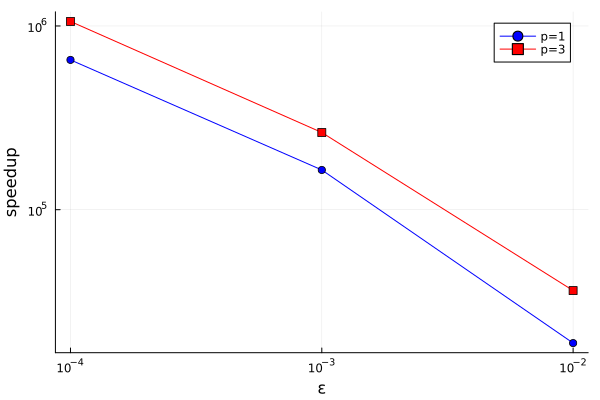

In [7]:
plt_speedup = plot(eps, speedup_p1, color="blue", label="p=1", marker=:circle)
plot!(eps, speedup_p3, color="red", label="p=3", xlabel="ε", ylabel="speedup", marker=:square)
xaxis!(plt_speedup, :log)
yaxis!(plt_speedup, :log)